In [102]:
import os
from glob import glob
import pandas as pd
from functools import reduce
from xml.etree import ElementTree as et
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
import cv2
import random

In [103]:
#Load xml files and store in a list

base_dir = './dataset/train/'
xml_list = glob(base_dir + '*.xml', recursive = True)
xml_list

['./dataset/train/image1.xml', './dataset/train/image2.xml']

<b> Extract filename, width, height, name, xmin, xmax, ymin, ymax from the xml file </b>

In [104]:
def extract_text(filename):
    tree = et.parse(filename)
    root = tree.getroot()
    #extract filename
    image_name = root.find('filename').text

    #extract width and height of the image
    width = root.find('size').find('width').text
    height = root.find('size').find('height').text

    #Extract x,y coordinates and label name
    objs = root.findall('object')

    parser = []
    for obj in objs:
        name = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = bndbox.find('xmin').text
        ymin = bndbox.find('ymin').text
        xmax = bndbox.find('xmax').text
        ymax = bndbox.find('ymax').text
        parser.append([image_name, width, height,name,xmin,xmax,ymin,ymax])
    
    return parser

In [105]:
parser_all = list(map(extract_text,xml_list))
parser_all


[[['image1.jpg', '250', '250', 'dog', '3', '141', '19', '245'],
  ['image1.jpg', '250', '250', 'cat', '142', '193', '82', '226']],
 [['image2.jpg', '250', '250', 'dog', '17', '215', '10', '224']]]

In [106]:
data = reduce(lambda x,y : x+y, parser_all)
data

[['image1.jpg', '250', '250', 'dog', '3', '141', '19', '245'],
 ['image1.jpg', '250', '250', 'cat', '142', '193', '82', '226'],
 ['image2.jpg', '250', '250', 'dog', '17', '215', '10', '224']]

In [107]:
df = pd.DataFrame(data, columns = ['filename', 'width', 'height','class_name','xmin','xmax','ymin','ymax'])
df.head(10)

,filename,width,height,class_name,xmin,xmax,ymin,ymax
0,image1.jpg,250,250,dog,3,141,19,245
1,image1.jpg,250,250,cat,142,193,82,226
2,image2.jpg,250,250,dog,17,215,10,224


In [108]:
#convert columns into integer

cols = ['width', 'height', 'xmin', 'ymin', 'xmax', 'ymax']

df[cols] = df[cols].astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   filename    3 non-null      object
 1   width       3 non-null      int64 
 2   height      3 non-null      int64 
 3   class_name  3 non-null      object
 4   xmin        3 non-null      int64 
 5   xmax        3 non-null      int64 
 6   ymin        3 non-null      int64 
 7   ymax        3 non-null      int64 
dtypes: int64(6), object(2)
memory usage: 320.0+ bytes


In [109]:
def augment_data(image, image_name, df):
    category_ids = []
    bboxes = []

    # Convert the image to a NumPy array
    image_np = np.array(image)

    # group by filename
    group = df[df['filename'] == image_name]
    print(image_name)
    # Get bounding boxes on coordinates of the image
    for index, row in group.iterrows():
        bboxes.append([row['xmin'], row['ymin'], row['xmax'], row['ymax']])
        category_ids.append(row['class_name'])

    # Define the bounding box parameters
    bbox_params = A.BboxParams(format='pascal_voc', min_visibility=0.7, label_fields=['category_ids'])
    # Define the transformation
    transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5)
         ],  
        bbox_params = bbox_params)
    # Apply the transformation to both the image and bounding box
    random.seed(7)
    transformed = transform(image=image_np, bboxes=bboxes, category_ids=category_ids)
    transformed_image = transformed['image']
    transformed_bbox = transformed['bboxes']
    
    return(transformed_image, transformed_bbox)
    

    

In [91]:
def write_xml(xml_path, new_output_path_xml, transformed_bbox):
    tree = et.parse(xml_path)
    root = tree.getroot()

        
    for i,obj in enumerate(root.iter('object')):
        for box in obj.iter('bndbox'):
            xmin, ymin, xmax, ymax = transformed_bbox[i]
            box.find('xmin').text = str(xmin)
            box.find('ymin').text = str(ymin)
            box.find('xmax').text = str(xmax)
            box.find('ymax').text = str(ymax)
            

    tree.write(new_output_path_xml)

In [110]:
original_folder = './dataset/train/'
images_names = [f for f in os.listdir(original_folder) if f.endswith(('.jpg', '.jpeg', '.png'))]
augmented_folder = './dataset/train/augmentation'

os.makedirs(augmented_folder, exist_ok=True)


for image_name in images_names:
    image_path = os.path.join(original_folder, image_name)
    image = cv2.imread(image_path)
    base_filename = os.path.splitext(os.path.basename(image_path))[0]
    print("Processing the file : ",base_filename, "\n")

    xml_path = os.path.join(original_folder, (base_filename + '.xml'))

    new_image_name = base_filename + '_augment.jpg'
    new_xml_name = base_filename + '_augment.xml'
    

    output_path_image = os.path.join(augmented_folder, new_image_name)
    new_output_path_xml = os.path.join(augmented_folder, new_xml_name)
    
    transformed_image,transformed_bbox  = augment_data(image, (base_filename + ".jpg"), df)
    cv2.imwrite(output_path_image, transformed_image)  #write augmented image
    write_xml(xml_path, new_output_path_xml, transformed_bbox)  #call function to write augmented xml file


Processing the file :  image1 

image1.jpg
Processing the file :  image2 

image2.jpg


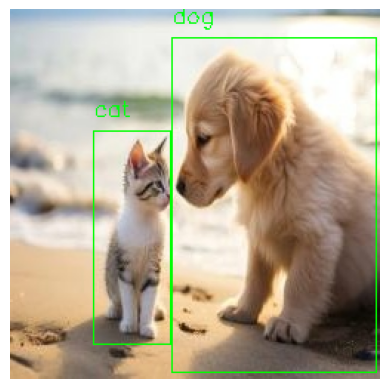

In [111]:
import matplotlib.pyplot as plt

def parse_pascal_voc(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    bboxes = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))
        
        bboxes.append((name, xmin, ymin, xmax, ymax))
    
    return bboxes

def draw_bboxes(image_path, bboxes):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for matplotlib

    for bbox in bboxes:
        name, xmin, ymin, xmax, ymax = bbox
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 1)
        cv2.putText(image, name, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 12), 1)
    
    plt.figure()
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()

# Example usage
xml_file = 'dataset/train/augmentation/image1_augment.xml'
image_file = 'dataset/train/augmentation/image1_augment.jpg'

bboxes = parse_pascal_voc(xml_file)
draw_bboxes(image_file, bboxes)
